# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from pyclustering.cluster.kmedians import kmedians
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.utils.metric import type_metric, distance_metric
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib as mpl
import seaborn as sns
from matplotlib import animation
from IPython.display import HTML

- This script applies PCA to reduce the dimensions of the California Housing dataset, followed by clustering using K-Medians with initialization via the k-means++ method. The script:
  1. Initializes centroids using k-means++ and performs K-Medians clustering with Manhattan distance.
  2. Assigns cluster labels to each data point and visualizes the geographical distribution of clusters using latitude and longitude coordinates.
  3. Includes an animation demonstrating the iterative process of centroids moving to their optimal positions in real-time.
- Each cluster is color-coded and mapped with respect to their geographic location to provide a visual understanding of the cluster spread.
- Additional plotting configurations enhance the readability and aesthetics of the outputs.

# Data Loading & Preprocessing

In [2]:
path = 'C:\\Users\\zcindemir\\Desktop\\Data Mining Project\\housing.csv'
housing = pd.read_csv(path)

housing['total_bedrooms'].fillna(housing['total_bedrooms'].median(), inplace=True)

encoder = OneHotEncoder()
ocean_proximity_encoded = encoder.fit_transform(housing[['ocean_proximity']]).toarray()
feature_names = encoder.get_feature_names_out(['ocean_proximity'])
ocean_proximity_df = pd.DataFrame(ocean_proximity_encoded, columns=feature_names)
housing_encoded = pd.concat([housing.drop('ocean_proximity', axis=1), ocean_proximity_df], axis=1)

scaler = StandardScaler()
housing_scaled = scaler.fit_transform(housing_encoded)

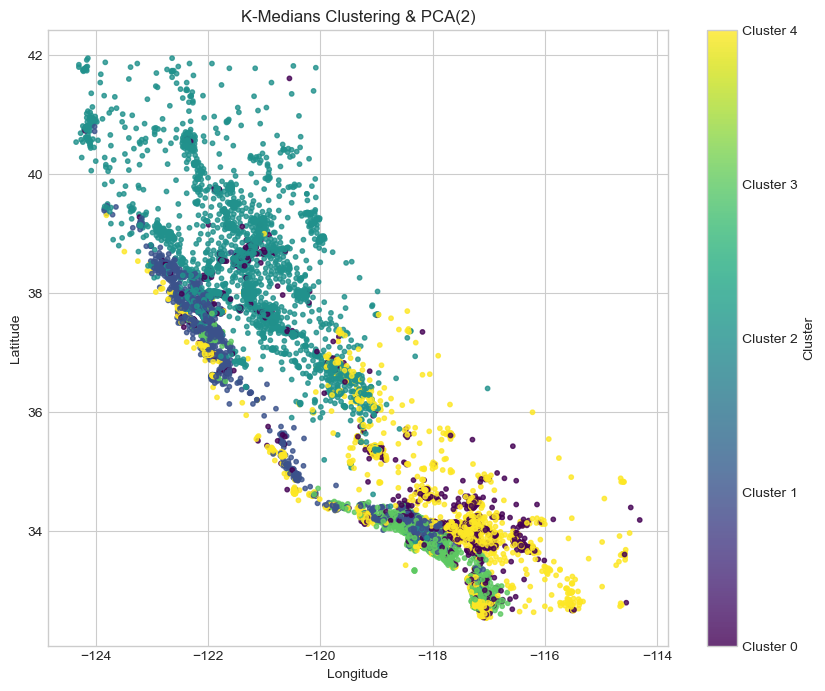

In [3]:
pca = PCA(n_components=4)
housing_pca = pca.fit_transform(housing_scaled)

initial_medians = kmeans_plusplus_initializer(housing_pca, 5).initialize()
manhattan_metric = distance_metric(type_metric.MANHATTAN)

kmedians_instance = kmedians(housing_pca, initial_medians, metric=manhattan_metric)
kmedians_instance.process()

clusters = kmedians_instance.get_clusters()
medians = kmedians_instance.get_medians()


labels = np.zeros(housing_pca.shape[0], dtype=int) - 1
for cluster_id, cluster in enumerate(clusters):
    for index in cluster:
        labels[index] = cluster_id


colors = plt.cm.viridis(np.linspace(0, 1, len(clusters)))

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(10, 8))
scatter = plt.scatter(housing['longitude'], housing['latitude'], c=labels, cmap='viridis', s=10, alpha=0.8)
colorbar = plt.colorbar(scatter, label='Cluster')
colorbar.set_ticks(np.arange(len(clusters)))
colorbar.set_ticklabels([f'Cluster {i}' for i in range(len(clusters))])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('K-Medians Clustering & PCA(4)')
plt.show()

In [4]:
mpl.rc('animation', html='html5')
plt.style.use(style="seaborn-v0_8-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

def initialize_centroids(points, k):
    centroids = points.copy()
    np.random.shuffle(centroids)
    return centroids[:k]

def closest_centroid(points, centroids):
    distances = np.sqrt(((points - centroids[:, np.newaxis]) ** 2).sum(axis=2))
    return np.argmin(distances, axis=0)

def move_centroids(points, closest, centroids):
    return np.array([np.median(points[closest == k], axis=0) for k in range(centroids.shape[0])])

k = 6
centroids = initialize_centroids(housing_scaled, k)

colors = sns.color_palette(n_colors=k)
fig, ax = plt.subplots(figsize=(10, 8))

longitude_index = housing_encoded.columns.get_loc("longitude")
latitude_index = housing_encoded.columns.get_loc("latitude")

def animate(i):
    global centroids
    closest = closest_centroid(housing_scaled, centroids)
    centroids = move_centroids(housing_scaled, closest, centroids)
    
    ax.clear()
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    
    ax.scatter(housing_encoded['longitude'], housing_encoded['latitude'], c='gray', alpha=0.1)
    
    for idx in range(k):
        cluster_points = housing_scaled[closest == idx]
        points = scaler.inverse_transform(cluster_points)
        ax.scatter(points[:, longitude_index], points[:, latitude_index], c=[colors[idx]], alpha=0.6)

    centroid_points = scaler.inverse_transform(centroids)
    ax.scatter(centroid_points[:, longitude_index], centroid_points[:, latitude_index], c='red', s=100, edgecolors='k', marker='X')
    ax.set_xlim([housing['longitude'].min(), housing['longitude'].max()])
    ax.set_ylim([housing['latitude'].min(), housing['latitude'].max()])

ani = animation.FuncAnimation(fig, animate, frames=25, interval=300)


plt.close()
HTML(ani.to_jshtml())